# Developing "Momentum" Trading Strategy
* Many differnt takes on this strategy
* Sometimes referred to as trend following
* Whatever you do and call it, you first need to research potential trading signals

In [17]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt


### 1. Download data: 
* Many services for this, some paid some free 
* Yahoo Finance API
* Typically trading "systems" involve a number of securities
* For this demonstration we are just going to look at GLD --> the gold ETF

In [18]:
result = pd.read_csv(r'E:\Data_Stock\excel_bcg.csv')
result["Date"] = pd.to_datetime(result["<DTYYYYMMDD>"], format='%Y%m%d')
result['Open'] = pd.to_numeric(result['<OpenFixed>'].astype(str)) * 1000
result['Close'] = pd.to_numeric(result['<CloseFixed>'].astype(str)) * 1000
result['High'] = pd.to_numeric(result['<HighFixed>'].astype(str)) * 1000
result['Low'] = pd.to_numeric(result['<LowFixed>'].astype(str)) * 1000
result['Volume'] = pd.to_numeric(result['<Volume>'].astype(str))
gld = result[['Date','Open','High','Low' ,'Close','Volume']].copy()
gld.head()

,Date,Open,High,Low,Close,Volume
0,2015-07-16,9308.4,10154.6,9139.2,10098.2,2201970
1,2015-07-17,10098.2,10775.2,9929.0,10718.8,1585500
2,2015-07-20,10718.8,11452.2,10662.4,11283.0,1404650
3,2015-07-21,11226.6,11226.6,10493.2,10493.2,163790
4,2015-07-22,9759.8,9759.8,9759.8,9759.8,1860


In [19]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690 entries, 0 to 1689
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1690 non-null   datetime64[ns]
 1   Open    1690 non-null   float64       
 2   High    1690 non-null   float64       
 3   Low     1690 non-null   float64       
 4   Close   1690 non-null   float64       
 5   Volume  1690 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 79.3 KB


### 2. Add data/transform data
* calculate signal based on some price or statistical action
* we are going to try a moving average crossover to generate signals
* for this strategy we will always by "in" a trade, either long or short
* we are modeling; this means real life variation should be expected

#### Add moving averages to the data frame

In [20]:
gld['9-day'] = gld['Close'].rolling(9).mean()
gld['21-day'] = gld['Close'].rolling(21).mean()
gld[19:25]

,Date,Open,High,Low,Close,Volume,9-day,21-day
19,2015-08-12,9026.4,9139.2,8970.0,9026.4,518400,8969.966667,NaN
20,2015-08-13,8970.0,9082.8,8857.2,9026.4,568170,8982.511111,9415.909524
21,2015-08-14,9026.4,9139.2,8913.6,8970.0,461220,9001.322222,9362.185714
22,2015-08-17,8970.0,9082.8,8857.2,8913.5,448820,8988.777778,9276.219048
23,2015-08-18,8913.5,9026.3,8857.1,8970.0,506950,8982.511111,9166.076190
24,2015-08-19,8913.6,8913.6,8744.3,8913.5,496190,8969.966667,9090.852381


#### Add "signal" column  

In [21]:
gld['signal'] = np.where(gld['9-day'] > gld['21-day'], 1, 0)
gld['signal'] = np.where(gld['9-day'] < gld['21-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,Date,Open,High,Low,Close,Volume,9-day,21-day,signal
20,2015-08-13,8970.0,9082.8,8857.2,9026.4,568170,8982.511111,9415.909524,-1
21,2015-08-14,9026.4,9139.2,8913.6,8970.0,461220,9001.322222,9362.185714,-1
22,2015-08-17,8970.0,9082.8,8857.2,8913.5,448820,8988.777778,9276.219048,-1
23,2015-08-18,8913.5,9026.3,8857.1,8970.0,506950,8982.511111,9166.076190,-1
24,2015-08-19,8913.6,8913.6,8744.3,8913.5,496190,8969.966667,9090.852381,-1


#### Calculate Instantaneous returns/system returns

In [22]:
gld['return'] = np.log(gld['Close']).diff()
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.head()

,Date,Open,High,Low,Close,Volume,9-day,21-day,signal,return,system_return,entry
20,2015-08-13,8970.0,9082.8,8857.2,9026.4,568170,8982.511111,9415.909524,-1,NaN,NaN,NaN
21,2015-08-14,9026.4,9139.2,8913.6,8970.0,461220,9001.322222,9362.185714,-1,-0.006268,0.006268,0.0
22,2015-08-17,8970.0,9082.8,8857.2,8913.5,448820,8988.777778,9276.219048,-1,-0.006319,0.006319,0.0
23,2015-08-18,8913.5,9026.3,8857.1,8970.0,506950,8982.511111,9166.076190,-1,0.006319,-0.006319,0.0
24,2015-08-19,8913.6,8913.6,8744.3,8913.5,496190,8969.966667,9090.852381,-1,-0.006319,0.006319,0.0


#### Plot trades on time series

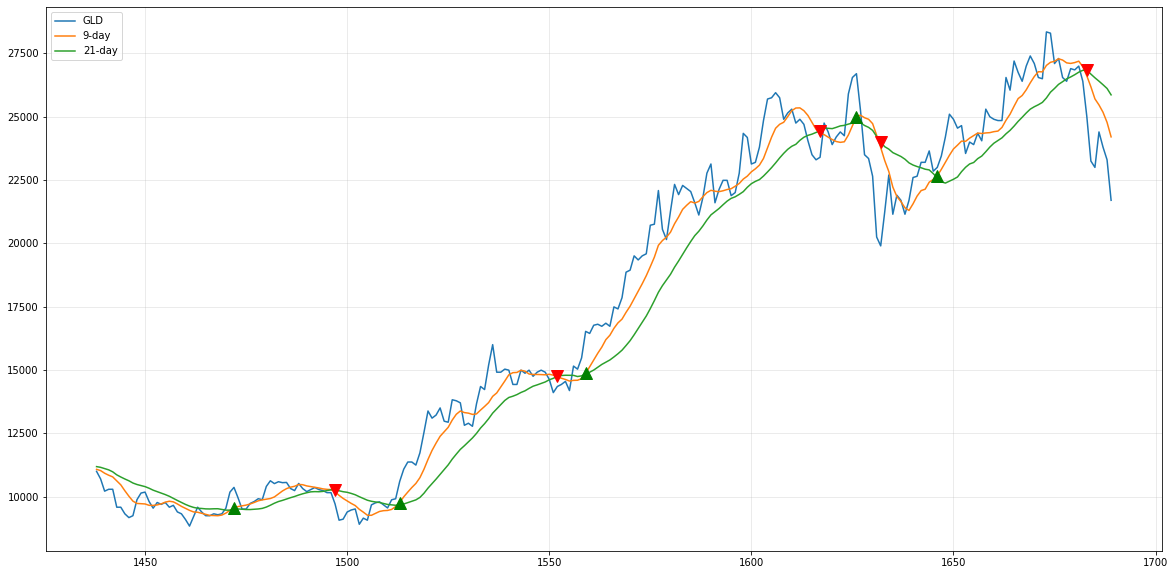

In [23]:
plt.rcParams['figure.figsize'] = 20, 10
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-252:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-252:]['9-day'], label = '9-day')
plt.plot(gld.iloc[-252:]['21-day'], label = '21-day')
plt.plot(gld[-252:].loc[gld.entry == 2].index, gld[-252:]['9-day'][gld.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-252:].loc[gld.entry == -2].index, gld[-252:]['21-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2)

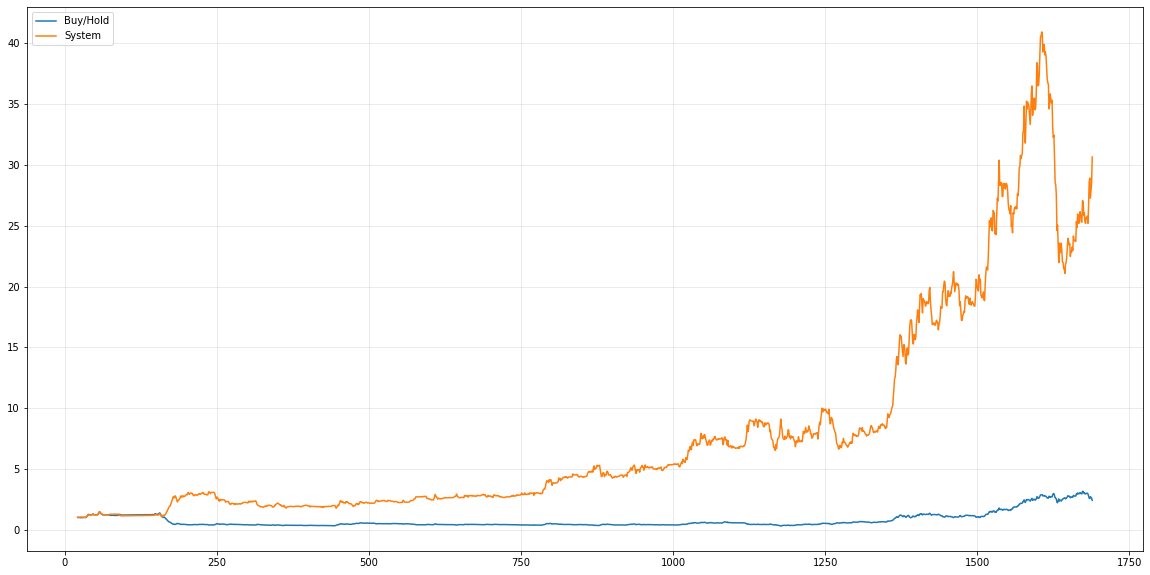

In [24]:
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)